In [8]:
# %matplotlib_svg
%pylab inline
# import pylab as pl
# import numpy as np
from scipy import signal
np.set_printoptions(precision=3, linewidth=120, suppress=False)

Populating the interactive namespace from numpy and matplotlib


## 頻域訊號處理

### FFT知識復習

In [9]:
x = np.random.rand(8)
xf = np.fft.fft(x)
print(x)
print(xf)

[ 0.247  0.246  0.973  0.543  0.22   0.775  0.8    0.68 ]
[  4.484e+00+0.j     -2.489e-01+0.298j  -1.306e+00+0.201j   3.043e-01+0.645j  -3.309e-03+0.j      3.043e-01-0.645j
  -1.306e+00-0.201j  -2.489e-01-0.298j]


In [10]:
np.fft.ifft(xf)

array([ 0.247 -6.939e-18j,  0.246 -1.388e-16j,  0.973 -7.633e-17j,  0.543 +6.940e-17j,  0.220 +6.939e-18j,
        0.775 +5.550e-17j,  0.800 +7.633e-17j,  0.680 +1.389e-17j])

In [11]:
x = np.ones(8)
np.fft.fft(x)/len(x) # 為了計算各個成分的能量，需要將FFT的結果除以FFT的長度

array([ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j])

In [12]:
x = np.arange(0, 2*np.pi, 2*np.pi/8)
y = np.sin(x)
tmp = np.fft.fft(y)/len(y)
print(np.array_str(tmp, suppress_small=True))

[ 0.+0.j  -0.-0.5j  0.-0.j   0.-0.j   0.+0.j   0.-0.j   0.+0.j   0.+0.5j]


In [13]:
tmp = np.fft.fft(np.cos(x))/len(x)
print(np.array_str(tmp, suppress_small=True))

[-0.0+0.j  0.5-0.j  0.0+0.j  0.0+0.j  0.0+0.j -0.0+0.j  0.0+0.j  0.5-0.j]


In [14]:
tmp = np.fft.fft(2*np.sin(2*x))/len(x)
print(np.array_str(tmp, suppress_small=True))
tmp = np.fft.fft(0.8*np.cos(2*x))/len(x)
print(np.array_str(tmp, suppress_small=True))

[ 0.+0.j  0.+0.j -0.-1.j  0.-0.j  0.+0.j  0.+0.j -0.+1.j  0.-0.j]
[-0.0+0.j -0.0+0.j  0.4-0.j  0.0-0.j  0.0+0.j  0.0-0.j  0.4+0.j -0.0+0.j]


In [15]:
x = np.arange(0, 2*np.pi, 2*np.pi/128)
y = 0.3*np.cos(x) + 0.5*np.cos(2*x+np.pi/4) + 0.8*np.cos(3*x-np.pi/3)
yf = np.fft.fft(y)/len(y)
print(np.array_str(yf[:4], suppress_small=True))
print(np.abs(yf[1]), np.rad2deg(np.angle(yf[1]))) # 周期為128取樣點的余弦波的振幅和相位
print(np.abs(yf[2]), np.rad2deg(np.angle(yf[2]))) # 周期為64取樣點的余弦波的振幅和相位
print(np.abs(yf[3]), np.rad2deg(np.angle(yf[3]))) # 周期為42.667取樣點的余弦波的振幅和相位

[ 0.000+0.j     0.150+0.j     0.177+0.177j  0.200-0.346j]
0.15 2.48480834489e-15
0.25 45.0
0.4 -60.0


In [16]:
x1 = np.random.random(4096)
x2 = np.random.random(4093)

%timeit np.fft.fft(x1)
%timeit np.fft.fft(x2)

10000 loops, best of 3: 134 µs per loop
10 loops, best of 3: 37.7 ms per loop


### 合成時域訊號

/home/wei/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in log10


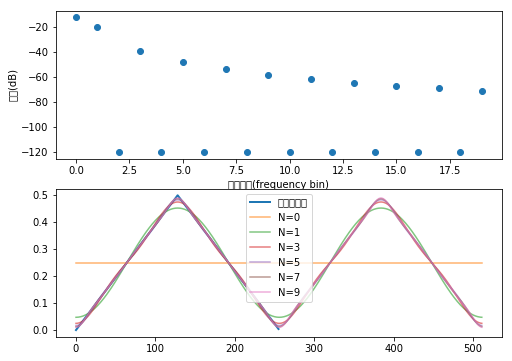

In [17]:
#%fig=三角波的頻譜（上）、使用頻譜中的部分頻率重建的三角波（下）
def triangle_wave(size): #❶
    x = np.arange(0, 1, 1.0/size)
    y = np.where(x<0.5, x, 0)
    y = np.where(x>=0.5, 1-x, y)
    return x, y
    
# 取FFT計算的結果bins中的前n項進行合成，傳回合成結果，計算loops個周期的波形
def fft_combine(bins, n, loops=1): #❷
    length = len(bins) * loops
    data = np.zeros(length)
    index = loops * np.arange(0, length, 1.0) / length * (2 * np.pi)
    for k, p in enumerate(bins[:n]):
        if k != 0: p *= 2 # 除去直流成分之外，其余的系數都*2
        data += np.real(p) * np.cos(k*index) # 余弦成分的系數為實數部
        data -= np.imag(p) * np.sin(k*index) # 正弦成分的系數為負的虛數部
    return index, data       

fft_size = 256

# 計算三角波和其FFT
x, y = triangle_wave(fft_size)
fy = np.fft.fft(y) / fft_size

# 繪制三角波的FFT的前20項的振幅，由於不含索引為偶數的值均為0， 因此取
# log之後無窮小，無法繪圖，用np.clip函數設定陣列值的上下限，確保繪圖正確
fig, axes = pl.subplots(2, 1, figsize=(8, 6))
axes[0].plot(np.clip(20*np.log10(np.abs(fy[:20])), -120, 120), "o")
axes[0].set_xlabel(u"頻率視窗(frequency bin)")
axes[0].set_ylabel(u"幅值(dB)")

# 繪制原始的三角波和用正弦波逐級合成的結果，使用取樣點為x軸座標
axes[1].plot(y, label=u"原始三角波", linewidth=2)
for i in [0,1,3,5,7,9]:
    index, data = fft_combine(fy, i+1, 2)  # 計算兩個周期的合成波形
    axes[1].plot(data, label = "N=%s" % i, alpha=0.6)
axes[1].legend(loc="best");

/home/wei/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10


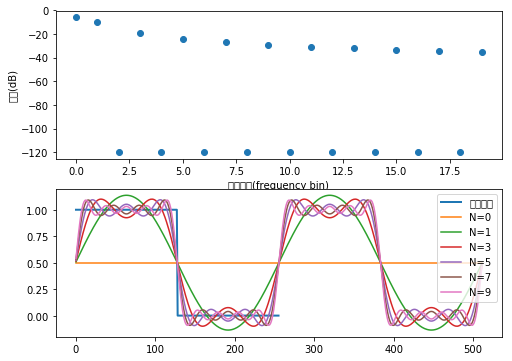

In [18]:
#%fig=方波的頻譜、合成方波在跳變處出現抖動
def square_wave(size):
    x = np.arange(0, 1, 1.0/size)
    y = np.where(x<0.5, 1.0, 0)
    return x, y

x, y = square_wave(fft_size)
fy = np.fft.fft(y) / fft_size

fig, axes = pl.subplots(2, 1, figsize=(8, 6))
axes[0].plot(np.clip(20*np.log10(np.abs(fy[:20])), -120, 120), "o")
axes[0].set_xlabel(u"頻率視窗(frequency bin)")
axes[0].set_ylabel(u"幅值(dB)")
axes[1].plot(y, label=u"原始方波", linewidth=2)
for i in [0,1,3,5,7,9]:
    index, data = fft_combine(fy, i+1, 2)  # 計算兩個周期的合成波形
    axes[1].plot(data, label = "N=%s" % i)
axes[1].legend(loc="best");

> **SOURCE**

> `scpy2.examples.fft_demo`：使用該程式可以交談式地觀察各種三角波和方波的頻譜以及其正弦合成的近似波形

In [19]:
#%hide
%exec_python -m scpy2.examples.fft_demo

ERROR:root:Line magic function `%exec_python` not found.


### 觀察訊號的頻譜

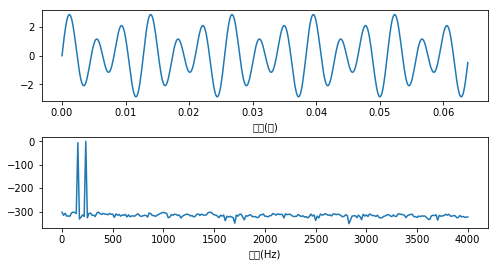

In [20]:
#%fig=156.25Hz和234.375Hz的波形（上）和頻譜（下）
sampling_rate, fft_size = 8000, 512      #❶
t = np.arange(0, 1.0, 1.0/sampling_rate) #❷
x = np.sin(2*np.pi*156.25*t)  + 2*np.sin(2*np.pi*234.375*t) #❸

def show_fft(x):
    xs = x[:fft_size]
    xf = np.fft.rfft(xs)/fft_size #❹
    freqs = np.linspace(0, sampling_rate/2, fft_size/2+1) #❺
    xfp = 20*np.log10(np.clip(np.abs(xf), 1e-20, 1e100)) #❻
    pl.figure(figsize=(8,4))
    pl.subplot(211)
    pl.plot(t[:fft_size], xs)
    pl.xlabel(u"時間(秒)")
    pl.subplot(212)
    pl.plot(freqs, xfp)
    pl.xlabel(u"頻率(Hz)")
    pl.subplots_adjust(hspace=0.4)
    
show_fft(x)

In [22]:
print(xfp[[10, 15]])

NameError: name 'xfp' is not defined

In [24]:
freqs = np.fft.fftfreq(fft_size, 1.0/sampling_rate)
for i in [0, 1, fft_size//2-1, fft_size//2, fft_size//2+1, fft_size-2, fft_size-1]:
    print(i, "\t", freqs[i])

0 	 0.0
1 	 15.625
255 	 3984.375
256 	 -4000.0
257 	 -3984.375
510 	 -31.25
511 	 -15.625


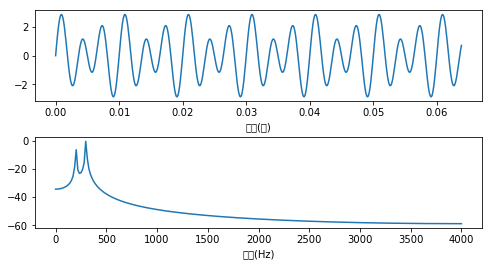

In [25]:
#%fig=非完整周期（200Hz和300Hz）的正弦波經由FFT變換之後出現頻譜洩漏
x = np.sin(2*np.pi*200*t)  + 2*np.sin(2*np.pi*300*t)
show_fft(x)

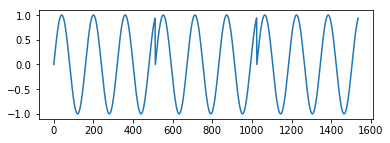

In [26]:
#%fig=50Hz正弦波的512點FFT所計算的頻譜的實際波形
pl.figure(figsize=(6, 2))
t = np.arange(0, 1.0, 1.0/8000)
x = np.sin(2*np.pi*50*t)[:512]
pl.plot(np.hstack([x, x, x]));

#### 窗函數

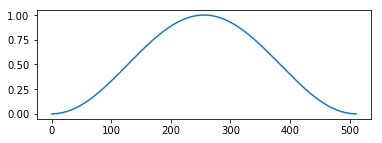

In [27]:
#%fig=Hann窗函數
from scipy import signal
pl.figure(figsize=(6, 2))
pl.plot(signal.hann(512));

In [28]:
print(signal.hann(8))
print(signal.hann(8, sym=0))

[ 0.     0.188  0.611  0.95   0.95   0.611  0.188  0.   ]
[ 0.     0.146  0.5    0.854  1.     0.854  0.5    0.146]


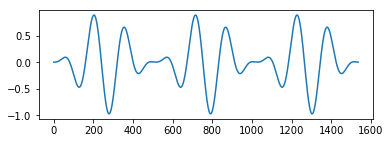

In [29]:
#%fig=加Hann窗的50Hz正弦波的512點FFT所計算的實際波形
pl.figure(figsize=(6, 2))
t = np.arange(0, 1.0, 1.0/8000)
x = np.sin(2*np.pi*50*t)[:512] * signal.hann(512, sym=0)
pl.plot(np.hstack([x, x, x]));

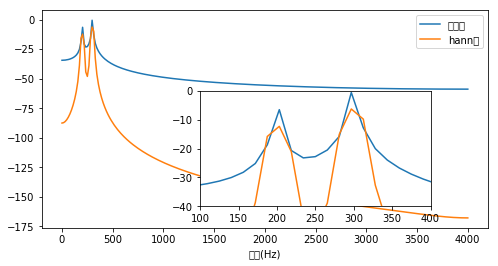

In [30]:
#%fig=加Hann窗前後的頻譜，Hann窗能降低頻譜洩漏
t = np.arange(0, 1.0, 1.0/sampling_rate)
x = np.sin(2*np.pi*200*t)  + 2*np.sin(2*np.pi*300*t)

xs = x[:fft_size] 
ys = xs * signal.hann(fft_size, sym=0)

xf = np.fft.rfft(xs)/fft_size
yf = np.fft.rfft(ys)/fft_size
freqs = np.linspace(0, sampling_rate/2, fft_size/2+1)
xfp = 20*np.log10(np.clip(np.abs(xf), 1e-20, 1e100))
yfp = 20*np.log10(np.clip(np.abs(yf), 1e-20, 1e100))
pl.figure(figsize=(8,4))
pl.plot(freqs, xfp, label=u"矩形窗")
pl.plot(freqs, yfp, label=u"hann窗")
pl.legend()
pl.xlabel(u"頻率(Hz)")

a = pl.axes([.4, .2, .4, .4])
a.plot(freqs, xfp, label=u"矩形窗")
a.plot(freqs, yfp, label=u"hann窗")
a.set_xlim(100, 400)
a.set_ylim(-40, 0);

In [31]:
np.mean(signal.hann(512, sym=0))

0.5

#### 頻譜平均

In [32]:
def average_fft(x, fft_size):
    n = len(x) // fft_size * fft_size
    tmp = x[:n].reshape(-1, fft_size)      #❶
    tmp *= signal.hann(fft_size, sym=0)    #❷
    xf = np.abs(np.fft.rfft(tmp)/fft_size) #❸
    avgf = np.mean(xf, axis=0)
    return 20*np.log10(avgf)

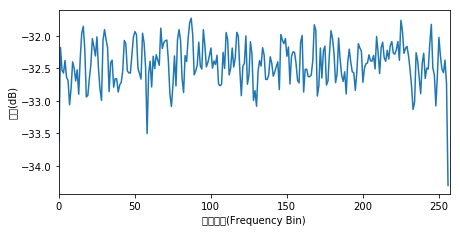

In [33]:
#%fig=白色噪聲的頻譜接近水平直線（注意Y軸的範圍）
x = np.random.randn(100000)
xf = average_fft(x, 512)
pl.figure(figsize=(7,3.5))
pl.plot(xf)
pl.xlabel(u"頻率視窗(Frequency Bin)")
pl.ylabel(u"幅值(dB)")
pl.xlim([0,257])
pl.subplots_adjust(bottom=0.15)

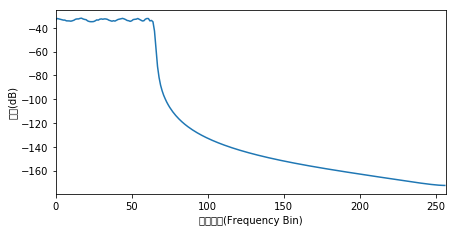

In [34]:
#%fig=經由低通濾波器的白噪聲的頻譜
b, a = signal.iirdesign(1000/4000.0, 1100/4000.0, 1, 40, 0, "cheby1")
x = np.random.randn(100000)
y = signal.filtfilt(b, a, x)
yf = average_fft(y, 512)
pl.figure(figsize=(7, 3.5))
pl.plot(yf)
pl.xlabel(u"頻率視窗(Frequency Bin)")
pl.ylabel(u"幅值(dB)")
pl.xlim(0, 257)
pl.subplots_adjust(bottom=0.15)

#### 譜圖

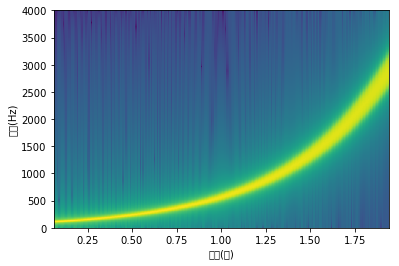

In [35]:
#%fig=頻率掃描波的譜圖
sampling_rate = 8000.0
fft_size = 1024
step = fft_size/16
time = 2

t = np.arange(0, time, 1/sampling_rate)
sweep = signal.chirp(t, f0=100, t1 = time, f1=0.8*sampling_rate/2, method="logarithmic")

pl.specgram(sweep, fft_size, sampling_rate, noverlap = 1024-step)
pl.xlabel(u"時間(秒)")
pl.ylabel(u"頻率(Hz)");

> **SOURCE**

> `scpy2.examples.spectrogram_realtime`：實時觀察音效訊號譜圖的示範程式，使用TraitsUI、PyAudio等庫實現

In [36]:
#%hide
%exec_python -m scpy2.examples.spectrogram_realtime

ERROR:root:Line magic function `%exec_python` not found.


#### 精確測量訊號頻率

In [37]:
def make_wave(amp, freq, phase, tend, rate):
    period = 1.0 / rate
    t = np.arange(0, tend, period)
    x = np.zeros_like(t)
    for a, f, p in zip(amp, freq, phase):
        x += a * np.sin(2*np.pi*f*t + p)
    return t, x

RATE = 8000
t, x = make_wave([1, 2, 0.5], [44, 150, 330], [1, 1.4, 1.8], 0.3, RATE)
x += np.random.randn(len(x))

In [38]:
FFT_SIZE = 1024
spect1 = np.fft.rfft(x[:FFT_SIZE] * np.hanning(FFT_SIZE))
freqs = np.fft.fftfreq(FFT_SIZE, 1.0/RATE)

bin_width = freqs[1] - freqs[0]

amp_spect1 = np.abs(spect1)
loc, = signal.argrelmax(amp_spect1, order=3) #❶
mask = amp_spect1[loc] > amp_spect1.mean() * 3   #❷
loc = loc[mask]
peak_freqs = freqs[loc]
print("bin width:", bin_width)
print("Peak Frequencies:", peak_freqs)

bin width: 7.8125
Peak Frequencies: [  46.875  148.438  328.125]


In [39]:
COUNT = FFT_SIZE//4
dt = COUNT / 8000.0

spect2 = np.fft.rfft(x[COUNT:COUNT+FFT_SIZE] * np.hanning(FFT_SIZE))

phase1 = np.angle(spect1[loc])
phase2 = np.angle(spect2[loc])

phase_delta = phase2 - phase1
print(phase_delta)

[ 2.463 -1.246 -2.88 ]


In [40]:
max_n = (peak_freqs.max() + 3*bin_width) * dt #❶
n = np.arange(max_n)

possible_freqs = (phase_delta + 2*np.pi*n[:, None]) / (2 * np.pi * dt) #❷

idx = np.argmin(np.abs(peak_freqs - possible_freqs), axis=0)   #❸
peak_freqs2 = possible_freqs[idx, np.arange(len(peak_freqs))]  
print("Peak Frequencies:", peak_freqs2)

Peak Frequencies: [  43.501  150.054  329.424]


### 卷冊積運算

#### 快速卷冊積

In [41]:
def fft_convolve(a,b):
    n = len(a) + len(b) - 1
    N = 2**(int(np.log2(n)) + 1)  #❶
    A = np.fft.fft(a, N)          #❷
    B = np.fft.fft(b, N)
    return np.fft.ifft(A * B)[:n] #❸

a = np.random.rand(128)
b = np.random.rand(128)
c = np.convolve(a,b)
np.allclose(c, fft_convolve(a, b))

True

In [42]:
a=np.random.rand(10000)
b=np.random.rand(10000)
print(np.allclose(np.convolve(a, b), fft_convolve(a, b)))

%timeit np.convolve(a, b)
%timeit fft_convolve(a, b)

True
10 loops, best of 3: 41.8 ms per loop
100 loops, best of 3: 5.14 ms per loop


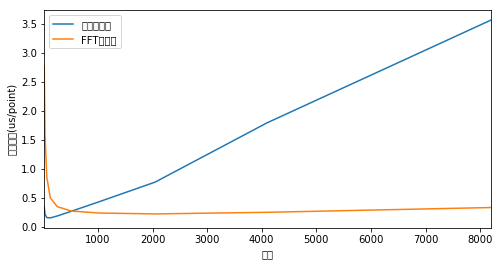

In [45]:
#%fig=比較直接卷冊積和FFT卷冊積的運算速度
results = []
for n in range(4, 14):
    N = 2**n
    a = np.random.rand(N)
    b = np.random.rand(N)
    tr1 = %timeit -r 1 -o -q np.convolve(a, b)
    tr2 = %timeit -r 1 -o -q fft_convolve(a, b)
    t1 = tr1.best * 1e6 / N
    t2 = tr2.best * 1e6 / N
    results.append((N, t1, t2))
results = np.array(results)

pl.figure(figsize=(8,4))
pl.plot(results[:, 0], results[:, 1], label=u"直接卷冊積")
pl.plot(results[:, 0], results[:, 2], label=u"FFT卷冊積")
pl.legend()
pl.ylabel(u"計算時間(us/point)")
pl.xlabel(u"長度")
n_list = results[:, 0]
pl.xlim(min(n_list),max(n_list));

#### 卷冊積的分段運算

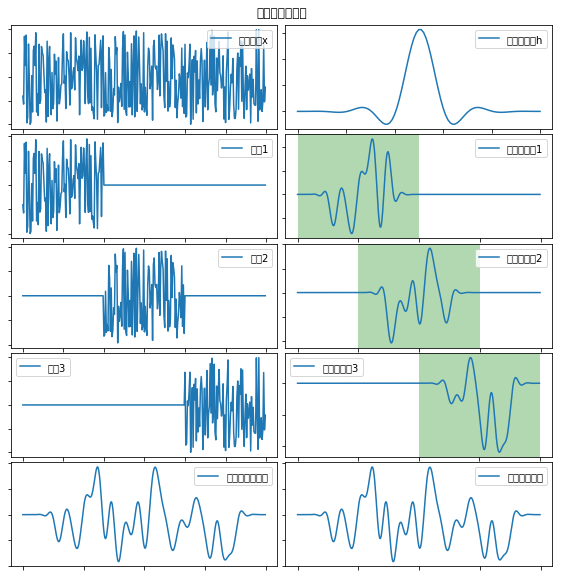

In [46]:
#%figonly=使用overlap-add法進行分段卷冊積的過程示範
def windowed_sinc(fc, M, K):
    i = np.arange(0,M,1.0)
    h = K * np.sin(2*np.pi*fc*(i-M/2.0))/(i-M/2.0)
    h *= 0.42 - 0.5*np.cos(2*np.pi*i/M) + 0.08*np.cos(4*np.pi*i/M)
    return h
    
x = np.random.rand(300) - 0.5   
h = windowed_sinc(0.05, 101, 1.0)

xs = []
for i in range(3):
    tmp = np.zeros(len(x), dtype=np.float64)
    tmp[i*100:i*100+100] = x[ i*100:i*100+100 ]
    xs.append(tmp)

y = np.convolve(x,h)
fig = pl.figure(figsize=(8, 8))

pl.subplot(521)
pl.plot(x, label=u"原始訊號x")
pl.gca().set_yticklabels([])
pl.gca().set_xticklabels([])
pl.legend()

pl.subplot(522)
pl.plot(h, label=u"濾波器系數h")
pl.gca().set_yticklabels([])
pl.gca().set_xticklabels([])
pl.legend()

result = []
for i,tmp in enumerate(xs):
    pl.subplot(520+3+i*2)
    pl.plot(tmp, label=u"分段%s" % (i+1))
    pl.gca().set_yticklabels([])
    pl.gca().set_xticklabels([])
    pl.legend()
    pl.subplot(520+3+i*2+1)
    tmp = np.convolve(tmp, h)
    result.append(tmp)
    pl.plot(tmp, label=u"分段卷冊積%s" % (i+1))
    pl.gca().set_yticklabels([])
    pl.gca().set_xticklabels([])  
    pl.axvspan(i*100,i*100+200,alpha=0.3,facecolor="g")
    pl.legend()

pl.subplot(529)
pl.plot(np.convolve(x,h), label=u"原始訊號卷冊積")
pl.gca().set_yticklabels([])
pl.gca().set_xticklabels([])  
pl.legend()

pl.subplot(5,2,10)
pl.plot(np.sum(result, axis=0), label=u"分段卷冊積和")
pl.gca().set_yticklabels([])
pl.gca().set_xticklabels([]) 
pl.legend()

pl.subplots_adjust(hspace=0.05, wspace=0.03, top=0.95, bottom=0.01,left=0.03,right=0.97)
pl.figtext(0.5, 0.965,  u"分段卷冊積示範",
           ha='center', color='black', weight='bold', size='large');

In [49]:
x = np.random.rand(1000)
h = np.random.rand(101)
y = np.convolve(x, h)

N = 50 # 分段大小
M = len(h) # 濾波器長度

output = []

#快取起始化為0
buffer = np.zeros(M+N-1,dtype=np.float64)

for i in range(int(len(x)/N)):
    #從輸入訊號中讀取N個資料
    xslice = x[i*N:(i+1)*N]
    #計算卷冊積
    yslice = np.convolve(xslice, h)
    #將卷冊積的結果加入到緩沖中
    buffer += yslice
    #輸出快取中的前N個資料，注意使用copy，否則輸出的是buffer的一個檢視
    output.append( buffer[:N].copy() ) #❶
    #快取中的資料左搬移N個元素
    buffer[0:-N] = buffer[N:]
    #後面的補0
    buffer[-N:] = 0

#將輸出的資料群組合為陣列
y2 = np.hstack(output)
#計算和直接卷冊積的結果之間的誤差
print("error:", np.max(np.abs( y2 - y[:len(x)] ) ))

error: 7.1054273576e-15
